In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from numpy.random import default_rng

import warnings
warnings.filterwarnings('ignore')

import sys
path_to_mavenn_local = '/Users/tareen/Desktop/Research_Projects/2020_mavenn_github/mavenn_local'
sys.path.insert(0,path_to_mavenn_local)

import mavenn
from mavenn.src.utils import get_example_dataset
from mavenn.src.utils import ge_plots_for_mavenn_demo
from mavenn.src.utils import onehot_encode_array, _generate_nbr_features_from_sequences, _generate_all_pair_features_from_sequences
from mavenn.src.utils import _center_matrix
from mavenn.src.utils import estimate_instrinsic_information

import tensorflow as tf
import tensorflow.keras.backend as K

In [42]:
mavenn.__path__

['/Users/tareen/Desktop/Research_Projects/2020_mavenn_github/mavenn_local/mavenn']

In [2]:
MPSA_data = pd.read_csv('20.08.16_mpsa_data/brca2_lib1_rep1.csv')
MPSA_data.head()

,ss,log_psi,dlog_psi
0,AAAGCAAAA,-3.751854,0.444200
1,AAAGCAAAC,-2.697741,0.369972
2,AAAGCAAAG,-2.242947,0.575121
3,AAAGCAAAT,-3.067251,0.357014
4,AAAGCAACA,-2.987074,0.472637


In [3]:
X = MPSA_data['ss'].values
y = MPSA_data['log_psi'].values
dy = MPSA_data['dlog_psi'].values

In [4]:
ix = (y > 0) & (dy > 0)

In [5]:
estimate_instrinsic_information(y[ix],dy[ix],True)

H[y]   = +1.0603 +- 0.0379 bits
H[y|x] = -1.7274 +- 0.0535 bits
I[y;x] = +2.7878 +- 0.0655 bits


(2.787797643056015, 0.06552233939699166)

In [6]:
from sklearn.model_selection import train_test_split
from mavenn.src.utils import ge_plots_for_mavenn_demo, get_example_dataset

# load data
#X, y = get_example_dataset(name='MPSA')

# X = X[0:50000].copy()
# y = y[0:50000].copy()

# split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, y)

# load mavenn's GE model
gpmap_type = 'pairwise'
noise_model = 'Gaussian'
GER = mavenn.Model(regression_type='GE',
                   X=x_train,
                   y=y_train,
                   gpmap_type=gpmap_type,
                   noise_model=noise_model,
                   monotonic=True,
                   learning_rate=0.0005,
                   num_nodes_hidden_measurement_layer=20,
                   alphabet='dna',
                   polynomial_order_ll=2)

In [7]:
GER.model.model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Sequence_labels_input (InputLay (None, 613)          0                                            
__________________________________________________________________________________________________
Sequence_only (Lambda)          (None, 612)          0           Sequence_labels_input[0][0]      
__________________________________________________________________________________________________
phi (Dense)                     (None, 1)            613         Sequence_only[0][0]              
__________________________________________________________________________________________________
dense (Dense)                   (None, 20)           40          phi[0][0]                        
__________________________________________________________________________________________________
y_hat (Den

In [8]:
GER.fit(epochs=50,
        early_stopping=False,
        #early_stopping_patience=15,
        validation_split=0.1,
        verbose=1)

# make predictions on held out test set

# predictions = GER.predict(x_test)

Train on 14801 samples, validate on 1645 samples
Epoch 1/50
14801/14801 [==============================] - 1s 56us/step - loss: 197.2593 - val_loss: 123.1459
Epoch 2/50
14801/14801 [==============================] - 0s 32us/step - loss: 103.9591 - val_loss: 85.6790
Epoch 3/50
14801/14801 [==============================] - 0s 32us/step - loss: 76.1359 - val_loss: 64.8495
Epoch 4/50
14801/14801 [==============================] - 0s 31us/step - loss: 58.1180 - val_loss: 49.9565
Epoch 5/50
14801/14801 [==============================] - 0s 32us/step - loss: 45.0273 - val_loss: 39.1907
Epoch 6/50
14801/14801 [==============================] - 0s 31us/step - loss: 35.8765 - val_loss: 32.0963
Epoch 7/50
14801/14801 [==============================] - 1s 36us/step - loss: 30.2579 - val_loss: 28.1563
Epoch 8/50
14801/14801 [==============================] - 1s 37us/step - loss: 27.3904 - val_loss: 26.3609
Epoch 9/50
14801/14801 [==============================] - 0s 31us/step - loss: 26.1468 - val

In [9]:
loss_history = GER.model.history

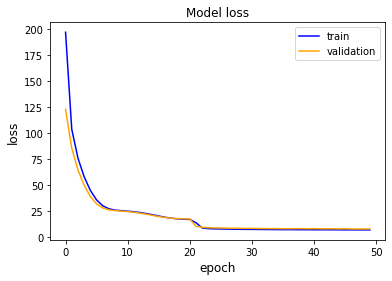

In [10]:
plt.plot(loss_history.history['loss'], color='blue')
plt.plot(loss_history.history['val_loss'], color='orange')
plt.title('Model loss', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.legend(['train', 'validation'])

In [11]:
yhat = GER.predict(x_test)
phi = GER.gpmap(x_test)


In [12]:
len(GER.get_nn().layers)

10

In [13]:
GER.get_nn().summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Sequence_labels_input (InputLay (None, 613)          0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 612)          0           Sequence_labels_input[0][0]      
__________________________________________________________________________________________________
phiPrime (Dense)                (None, 1)            613         lambda[0][0]                     
__________________________________________________________________________________________________
fix_diffeomorphic_mode (fixDiff (None, 1)            0           phiPrime[0][0]                   
__________________________________________________________________________________________________
phi (Dense

In [14]:
phi_range = np.linspace(min(phi),max(phi),1000)

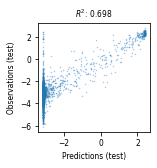

In [15]:
plt.figure(figsize=(2,2))
Rsq = np.corrcoef(yhat,y_test)[0][1]**2
plt.scatter(yhat,y_test,s=0.25,alpha=0.4)
plt.xlabel('Predictions (test)',fontsize=7.5)
plt.ylabel('Observations (test)',fontsize=7.5)
plt.title('$R^2$: '+str(Rsq)[0:5],fontsize=7.5)
plt.tick_params(labelsize=7.5)
#plt.savefig('mavenn_mpsa_additive_gaussian_observations_vs_preds_test.png',bbox_inches='tight',dpi=600)
plt.show()

# plt.figure(figsize=(5,5))
# Rsq = np.corrcoef(yhat,y_test)[0][1]**2
# plt.scatter(yhat,y_test,s=5,alpha=1)
# plt.xlabel('Predictions (test)',fontsize=12)
# plt.ylabel('Observations (test)',fontsize=12)
# plt.title('$R^2$: '+str(Rsq)[0:5],fontsize=12)
# plt.tick_params(labelsize=12)
# #plt.savefig('mavenn_mpsa_additive_gaussian_observations_vs_preds_test.png',bbox_inches='tight',dpi=600)
# plt.show()

In [16]:
#GER.model.model.summary()

In [17]:
# spline_order = np.arange(1,6,1)
# Rsq_spline_test = [0.234,0.467,0.518,0.527,0.552]

In [18]:
# plt.figure(figsize=(2,2))
# Rsq = np.corrcoef(yhat,y_test)[0][1]**2
# plt.scatter(spline_order,Rsq_spline_test,s=3, label='Epistasis')
# plt.axhline(0.641,lw=1.5,color='orange', label='MAVE-NN')
# plt.ylabel('$R^2$ (test)',fontsize=7.5)
# plt.xlabel('Spline order',fontsize=7.5)
# #plt.title('$R^2$: '+str(Rsq)[0:5],fontsize=7.5)
# plt.tick_params(labelsize=7.5)
# plt.xticks(spline_order)
# plt.yticks([0.2,0.3,0.4,0.5,0.6])
# plt.legend(fontsize=7)
# #plt.savefig('Rsq_vs_spline_order_mpsa.png',bbox_inches='tight',dpi=600)
# plt.show()





In [19]:
#plt.scatter(phi,y_test,s=1,alpha=0.5)

In [20]:
y_hat_GE = GER.ge_nonlinearity(phi_range)
GaussianNoiseModel = mavenn.GaussianNoiseModel(GER,y_hat_GE)

In [21]:
phi.shape, y_test.shape

((5483,), (5483,))

In [22]:
phi_single = 0.1
y_hat_of_phi = GER.ge_nonlinearity(phi_single)
p_of_y_given_phi = GaussianNoiseModel.p_of_y_given_phi(y_test,phi_single)
p_of_y_given_y_hat = GaussianNoiseModel.p_of_y_given_yhat(y_test,y_hat_of_phi)

(1, 1)


In [23]:
GaussianNoiseModel.p_of_y_given_yhat(1,1)

0.4184905311275903

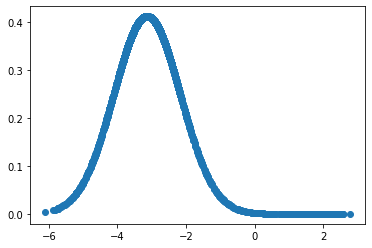

In [24]:
#plt.hist(p_of_y_given_y_hat.ravel(),bins=20)
plt.scatter(y_test.ravel(),p_of_y_given_y_hat.ravel())
plt.show()

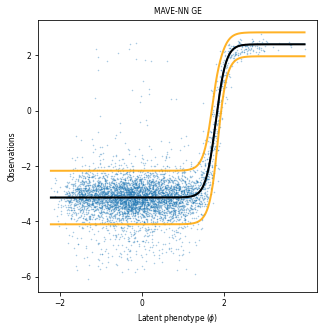

In [25]:


plt.figure(figsize=(5,5))
phi_range = np.linspace(min(phi),max(phi),1000)
plt.plot(phi_range,GER.ge_nonlinearity(phi_range))
plt.scatter(phi,y_test,s=0.25, alpha=0.4, label='Observations')
plt.plot(phi_range,GER.ge_nonlinearity(phi_range),lw=2,label='$\hat{y}$',alpha=1.0,color='black')
plt.plot(phi_range,y_hat_GE-GaussianNoiseModel.sigma,color='orange',lw=2,alpha=0.85,label='$\hat{y} \pm \sigma(\hat{y})$')
plt.plot(phi_range,y_hat_GE+GaussianNoiseModel.sigma,color='orange',lw=2,alpha=0.85)

plt.tick_params(labelsize=7.5)

# leg = plt.legend(fontsize=7,prop={'size': 5})
# for lh in leg.legendHandles: 
#     lh.set_alpha(1)
#     #lh.set_sizes([5.0])
      
#plt.ylim(-2,4)
# plt.yticks([-1,0,1,2,3])
plt.xticks([-2,0,2])
plt.ylabel('Observations',fontsize=7.5)
plt.xlabel('Latent phenotype ($\phi$)',fontsize=7.5)
#plt.title(noise_model+' Likelihood',fontsize=7.5)
plt.title('MAVE-NN GE',fontsize=7.5)
#plt.savefig('mpsa_additive_gaussian.png',bbox_inches='tight',dpi=600)
plt.show()


In [26]:
#GER.get_gpmap_parameters() 
#GER.model.model.layers[2].get_weights()[0]
36*4*4

576

In [27]:
from mavenn.src.utils import mi_continuous
import entropy_estimators as ee
I_estimated = ee.mi(y_test,yhat)

print(f'Pred info averaging: {GaussianNoiseModel.estimate_predictive_information(y_test,yhat)} bits')
print(f'Kraskov I_estimated: {I_estimated:.4f} bits')
print(f'Justins implementation: {mi_continuous(y_test,yhat)}')

Pred info averaging: (0.2927037038368059, 0.02258746389928063) bits
Kraskov I_estimated: 0.3759 bits
Justins implementation: (0.3752466397537901, 0.010717690231575401)


In [28]:
# yhat -> predictions for all values (e.g. in test set)
# y_test -> True values 

# compute log_2 of p_y_given_yhat for all values (i.e. in test set) and take mean.
# that's equal to 
mean_log_2_p_y_given_yhat = np.mean(np.log2(GaussianNoiseModel.p_of_y_given_yhat(y_test,yhat)))

In [29]:
# p(y) = <p(y|yhat)>, where the average is taken over the yhat values (i.e. in test data)
GaussianNoiseModel.p_of_y_given_yhat(y_test,yhat)

array([0.10755443, 0.4008427 , 0.38159606, ..., 0.20530868, 0.34530942,
       0.40894556])

In [30]:
GaussianNoiseModel.p_of_y_given_yhat(y_test[0],yhat)

array([0.10755442, 0.10755549, 0.10755499, ..., 0.01949624, 0.10755026,
       0.10755649], dtype=float32)

In [31]:
p_y = []
for _ in range(len(y_test)):
    
    '''
    form p_y by averaging over y_hat for every value of y_test
    i.e. 
    # p(y_1|y_hat_1), p(y_1|y_hat_1), ... ,p(y_1|y_hat_N), the mean of this is p(y_1)
    # p(y_2|y_hat_1), p(y_2|y_hat_1), ... ,p(y_2|y_hat_N), the mean of this is p(y_2), and so on.
    '''
    p_y.append(np.mean(GaussianNoiseModel.p_of_y_given_yhat(y_test[_],yhat).ravel()))
    
p_y = np.array(p_y)    
mean_log_2_p_y = np.mean(np.log2(p_y))
print(mean_log_2_p_y)

-1.9059476


In [32]:
mean_log_2_p_y_given_yhat-mean_log_2_p_y

0.2927037038368059

## Probability calculations

In [33]:
polynomial_weights = GER.model.model.layers[9].get_weights()[0].copy()

def p_of_y_given_yhat(y,yhat):
    
    #polynomial_weights = GER.model.model.layers[9].get_weights()[0].copy()
    
    logsigma=0
    
    for polynomial_index in range(len(polynomial_weights)):
        logsigma+= polynomial_weights[polynomial_index][0]*np.power(yhat,polynomial_index)

    sigma = np.exp(logsigma)

    
    return (1/np.sqrt(2*np.pi*sigma**2))*np.exp(-((y-yhat)**2)/(2*sigma**2))

In [34]:
print('MPSA-BRCA2-additive')
mean_log_2_p_y_given_yhat = -np.mean(np.log2(p_of_y_given_yhat(y_test,yhat)))
print('log2_p_y_given_yhat:',mean_log_2_p_y_given_yhat)
print('SEM:',np.std(np.log2(p_of_y_given_yhat(y_test,yhat)))/np.sqrt(len(y_test)))

MPSA-BRCA2-additive
log2_p_y_given_yhat: 1.6132438621956038
SEM: 0.0165717343837403


In [35]:
p_y = []
for _ in range(len(y_test)):
    
    #if _%500==0:
    #print(_)
    # form p_y by averaging over y_hat for every value of y_test
    p_y.append(np.mean(p_of_y_given_yhat(y_test[_],yhat).ravel()))
    
p_y = np.array(p_y)    
mean_log_2_p_y = -np.mean(np.log2(p_y))
print(mean_log_2_p_y)

1.9059476


In [36]:
p_of_y_given_yhat(y_test[0],yhat).ravel()

array([0.10755442, 0.10755549, 0.10755499, ..., 0.01949624, 0.10755026,
       0.10755649], dtype=float32)

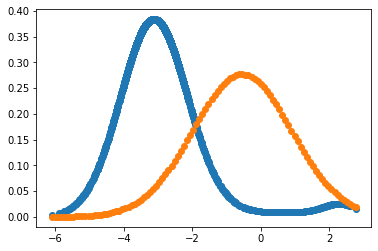

In [37]:
y_range = np.linspace(min(y_test),max(y_test),100)
p_y_range = p_of_y_given_yhat(y_range,-0.55)
plt.scatter(y_test,p_y)
plt.scatter(y_range,p_y_range)
plt.show()

In [38]:
I_y_test_y_hat = mean_log_2_p_y-mean_log_2_p_y_given_yhat
f'{I_y_test_y_hat} bits'

'0.2927037038368059 bits'

In [39]:
#mean_log_2_p_y_given_yhat-H_y

In [40]:
salmon

NameError: name 'salmon' is not defined

In [ ]:
#GER.get_gpmap_parameters()

Sailer Harms code

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from epistasis.models import EpistasisLinearRegression
from epistasis.pyplot import plot_coefs

from epistasis.models.nonlinear import EpistasisPowerTransform
from epistasis.pyplot.nonlinear import plot_power_transform

from gpmap import GenotypePhenotypeMap
MPSA_WT = 'CAGGUAAGU'
import mavenn
from mavenn.src.utils import get_example_dataset
X, y = get_example_dataset(name='MPSA')

gpm = GenotypePhenotypeMap(MPSA_WT,X,y)

# Fit Power transform
model = EpistasisPowerTransform(lmbda=3, A=0, B=0)
model.add_gpm(gpm)
model.fit()

# Create plot
fig, ax = plt.subplots(figsize=(10,10))
plot_power_transform(model, cmap='plasma', ax=ax, yerr=0.6, s=10)

ax.set_xlabel('Padd', fontsize=14)
ax.set_ylabel('Pobs', fontsize=14)
ax.set_title('Sailer/Harms, Power Transform - lmbda = 3')
fig.savefig('powerTransformLambda3.png',bbox_inches='tight')

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from epistasis.models import EpistasisLinearRegression
from epistasis.pyplot import plot_coefs

from epistasis.models.nonlinear import EpistasisPowerTransform
from epistasis.pyplot.nonlinear import plot_power_transform

from epistasis.models import EpistasisSpline

from gpmap import GenotypePhenotypeMap
MPSA_WT = 'CAGGUAAGU'
import mavenn
from mavenn.src.utils import get_example_dataset
X, y = get_example_dataset(name='MPSA')

gpm = GenotypePhenotypeMap(MPSA_WT,X,y)

# Fit Power transform
model = EpistasisSpline(k=3)
model.add_gpm(gpm)
model.fit()

# Create plot
fig, ax = plt.subplots(figsize=(10,10))
plot_power_transform(model, cmap='plasma', ax=ax, yerr=0.6, s=10)

ax.set_xlabel('Padd', fontsize=14)
ax.set_ylabel('Pobs', fontsize=14)
ax.set_title('Sailer/Harms, Model Spline')
fig.savefig('ModelSpline.png',bbox_inches='tight')

In [ ]:
from gpmap import GenotypePhenotypeMap
from epistasis.models import EpistasisSpline

wildtype = 'AA'
genotypes = ['AA', 'AT', 'TA', 'TT']
phenotypes = [0.1, 0.2, 0.7, 1.2]

# Read genotype-phenotype map.
gpm = GenotypePhenotypeMap(wildtype, genotypes, phenotypes)

# Initialize the data.
model = EpistasisSpline(k=3)

# Add Genotype-phenotype map data.
model.add_gpm(gpm)

# Fit the model.
model.fit()